<a href="https://colab.research.google.com/github/Matigol09/curso-series-temporales/blob/master/covidrsl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 2.1MB 18.7MB/s 
     |████████████████████████████████| 9.5MB 31.0MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# Se indagará sobre un modelo que explique el número de muertes en un día t
# X(t)=p*#sintomaticos(t-18), 18 días atras.  Es decir como una proporción de los síntomáticos 18 días atras.
#sintomáticos t-18: proporción de asintomaticos * tasa de positividad * población.
#18 días es el promedio entre la aparición de síntomas y la muerte, y por lo tanto se netea con el tiempo que se demora en entregar resultados el test.  Por lo tanto,
#asumiremos que 18 días atras corresopnden a los casos confirmados asintomaticos. 

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

In [3]:
covid_data=pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv", sep=",")
tasa_positividad_chile=pd.read_csv("https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto49/Positividad_Diaria_Media_T.csv", sep=",")
sin_sintomas_chile=pd.read_csv("https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto27/CasosNuevosSinSintomas_T.csv", sep=",")

In [4]:
covid_data_chile=covid_data[covid_data['location']=="Chile"]

In [5]:
tasa_positividad_chile.head()

,Fecha,pcr,casos,positividad,mediamovil_positividad
0,2020-03-25,3290.0,220.0,0.0669,NaN
1,2020-03-26,4886.0,164.0,0.0336,NaN
2,2020-03-27,7387.0,304.0,0.0412,NaN
3,2020-03-28,3534.0,299.0,0.0846,NaN
4,2020-03-29,1777.0,230.0,0.1294,NaN


In [6]:
tasa_positividad_chile=tasa_positividad_chile[['Fecha','positividad']]

In [7]:
tasa_positividad_chile.head()

,Fecha,positividad
0,2020-03-25,0.0669
1,2020-03-26,0.0336
2,2020-03-27,0.0412
3,2020-03-28,0.0846
4,2020-03-29,0.1294


In [8]:
sin_sintomas_chile=sin_sintomas_chile[['Region','Total']]

In [9]:
sin_sintomas_chile=sin_sintomas_chile.rename(columns={"Region": "Fecha","Total":"Asintomaticos"})

In [10]:
sin_sintomas_chile.head()

,Fecha,Asintomaticos
0,2020-04-29,250.0
1,2020-04-30,108.0
2,2020-05-01,103.0
3,2020-05-02,181.0
4,2020-05-03,116.0


In [11]:
datos_contagios_chile=pd.merge(tasa_positividad_chile, sin_sintomas_chile,  how='left', left_on=['Fecha'], right_on = ['Fecha'])

In [12]:
datos_contagios_chile.tail()

,Fecha,positividad,Asintomaticos
154,2020-08-26,0.0677,316.0
155,2020-08-27,0.0644,450.0
156,2020-08-28,0.0617,543.0
157,2020-08-29,0.0631,645.0
158,2020-08-30,0.0565,616.0


In [13]:
covid_data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [14]:
datos_chile=pd.merge(covid_data_chile, datos_contagios_chile,  how='left', left_on=['date'], right_on = ['Fecha'])

In [15]:
datos_chile.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,Fecha,positividad,Asintomaticos
0,CHL,South America,Chile,2020-03-04,1.0,1.0,NaN,0.0,0.0,NaN,0.052,0.052,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,19116209.0,24.282,35.4,11.087,6.938,22767.037,1.3,127.993,8.46,34.2,41.5,NaN,2.11,80.18,NaN,NaN,NaN
1,CHL,South America,Chile,2020-03-05,3.0,2.0,NaN,0.0,0.0,NaN,0.157,0.105,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,19116209.0,24.282,35.4,11.087,6.938,22767.037,1.3,127.993,8.46,34.2,41.5,NaN,2.11,80.18,NaN,NaN,NaN
2,CHL,South America,Chile,2020-03-06,4.0,1.0,NaN,0.0,0.0,NaN,0.209,0.052,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,19116209.0,24.282,35.4,11.087,6.938,22767.037,1.3,127.993,8.46,34.2,41.5,NaN,2.11,80.18,NaN,NaN,NaN
3,CHL,South America,Chile,2020-03-07,5.0,1.0,NaN,0.0,0.0,NaN,0.262,0.052,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,19116209.0,24.282,35.4,11.087,6.938,22767.037,1.3,127.993,8.46,34.2,41.5,NaN,2.11,80.18,NaN,NaN,NaN
4,CHL,South America,Chile,2020-03-09,10.0,5.0,NaN,0.0,0.0,NaN,0.523,0.262,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,19116209.0,24.282,35.4,11.087,6.938,22767.037,1.3,127.993,8.46,34.2,41.5,NaN,2.11,80.18,NaN,NaN,NaN


In [16]:
datos_chile=datos_chile[['date','new_deaths','new_cases', 'positividad','Asintomaticos']]

In [17]:
datos_chile

,date,new_deaths,new_cases,positividad,Asintomaticos
0,2020-03-04,0.0,1.0,NaN,NaN
1,2020-03-05,0.0,2.0,NaN,NaN
2,2020-03-06,0.0,1.0,NaN,NaN
3,2020-03-07,0.0,1.0,NaN,NaN
4,2020-03-09,0.0,5.0,NaN,NaN
...,...,...,...,...,...
174,2020-08-26,42.0,1417.0,0.0677,316.0
175,2020-08-27,32.0,1380.0,0.0644,450.0
176,2020-08-28,82.0,1737.0,0.0617,543.0
177,2020-08-29,60.0,1870.0,0.0631,645.0


In [18]:
datos_chile['new_cases_sintomas']=datos_chile['new_cases']-datos_chile['Asintomaticos']


In [19]:
datos_chile.head()

,date,new_deaths,new_cases,positividad,Asintomaticos,new_cases_sintomas
0,2020-03-04,0.0,1.0,NaN,NaN,NaN
1,2020-03-05,0.0,2.0,NaN,NaN,NaN
2,2020-03-06,0.0,1.0,NaN,NaN,NaN
3,2020-03-07,0.0,1.0,NaN,NaN,NaN
4,2020-03-09,0.0,5.0,NaN,NaN,NaN


In [20]:
datos_chile.date = pd.to_datetime(datos_chile.date,format="%Y-%m-%d")
datos_chile=datos_chile.set_index('date')

In [21]:
datos_1=datos_chile[['new_deaths']]
datos_2=datos_chile[['new_cases_sintomas']]

In [22]:
datos_2.head()

,new_cases_sintomas
date,
2020-03-04,NaN
2020-03-05,NaN
2020-03-06,NaN
2020-03-07,NaN
2020-03-09,NaN


In [23]:
datos_2

,new_cases_sintomas
date,
2020-03-04,NaN
2020-03-05,NaN
2020-03-06,NaN
2020-03-07,NaN
2020-03-09,NaN
...,...
2020-08-26,1101.0
2020-08-27,930.0
2020-08-28,1194.0


In [24]:
from datetime import timedelta 
datos_2.index=datos_2.index + timedelta(days=18)

In [25]:
datos_2.tail()

,new_cases_sintomas
date,
2020-09-13,1101.0
2020-09-14,930.0
2020-09-15,1194.0
2020-09-16,1225.0
2020-09-17,1421.0


In [26]:
datos_chile=pd.merge(datos_1, datos_2,  how='outer', left_on=['date'], right_on = ['date'])

In [27]:
datos_chile.head()

,new_deaths,new_cases_sintomas
date,,
2020-03-04,0.0,NaN
2020-03-05,0.0,NaN
2020-03-06,0.0,NaN
2020-03-07,0.0,NaN
2020-03-09,0.0,NaN


In [28]:
datos_chile.tail()

,new_deaths,new_cases_sintomas
date,,
2020-09-13,NaN,1101.0
2020-09-14,NaN,930.0
2020-09-15,NaN,1194.0
2020-09-16,NaN,1225.0
2020-09-17,NaN,1421.0


In [29]:
datos_chile=datos_chile.asfreq('d')

In [30]:
from datetime import date
today=date.today()

In [31]:
datos_chile['new_cases_sintomas'].first_valid_index()

Timestamp('2020-05-17 00:00:00', freq='D')

In [32]:
datos_chile=datos_chile.loc[datos_chile['new_cases_sintomas'].first_valid_index():]

In [33]:
bad_idx_case = datos_chile.index[datos_chile['new_cases_sintomas']>10000]
bad_idx_death = datos_chile.index[datos_chile['new_deaths']>500]

In [34]:
datos_chile.loc[bad_idx_case,'new_cases_sintomas'] = np.nan
datos_chile.loc[bad_idx_death,'new_deaths'] = np.nan

In [35]:
datos_chile=datos_chile.interpolate()

In [36]:
datos_chile

,new_deaths,new_cases_sintomas
date,,
2020-05-17,27.0,302.0
2020-05-18,29.0,412.0
2020-05-19,28.0,1035.0
2020-05-20,31.0,804.0
2020-05-21,35.0,1311.0
...,...,...
2020-09-13,49.0,1101.0
2020-09-14,49.0,930.0
2020-09-15,49.0,1194.0


In [37]:
datos_chile_historicos=datos_chile.loc[:today]
datos_chile_forecast=datos_chile.loc[today+timedelta(days=1):]

In [38]:
datos_chile_historicos.tail()

,new_deaths,new_cases_sintomas
date,,
2020-08-27,32.0,1696.0
2020-08-28,82.0,1428.0
2020-08-29,60.0,1564.0
2020-08-30,49.0,1151.0
2020-08-31,49.0,1127.0


In [39]:
datos_chile_forecast.head()

,new_deaths,new_cases_sintomas
date,,
2020-09-01,49.0,1250.0
2020-09-02,49.0,1525.0
2020-09-03,49.0,1157.0
2020-09-04,49.0,1564.0
2020-09-05,49.0,1113.0


In [40]:
size = int(len(datos_chile_historicos)*0.9)
datos_chile_train=datos_chile_historicos.iloc[:size]
datos_chile_test=datos_chile_historicos.iloc[size+1:]

In [41]:
datos_chile_train.tail()

,new_deaths,new_cases_sintomas
date,,
2020-08-16,55.0,1531.0
2020-08-17,57.0,1387.0
2020-08-18,61.0,1511.0
2020-08-19,33.0,1691.0
2020-08-20,32.0,1518.0


In [42]:
datos_chile_test.head()

,new_deaths,new_cases_sintomas
date,,
2020-08-22,52.0,1412.0
2020-08-23,69.0,987.0
2020-08-24,60.0,1358.0
2020-08-25,64.0,1378.0
2020-08-26,42.0,1550.0


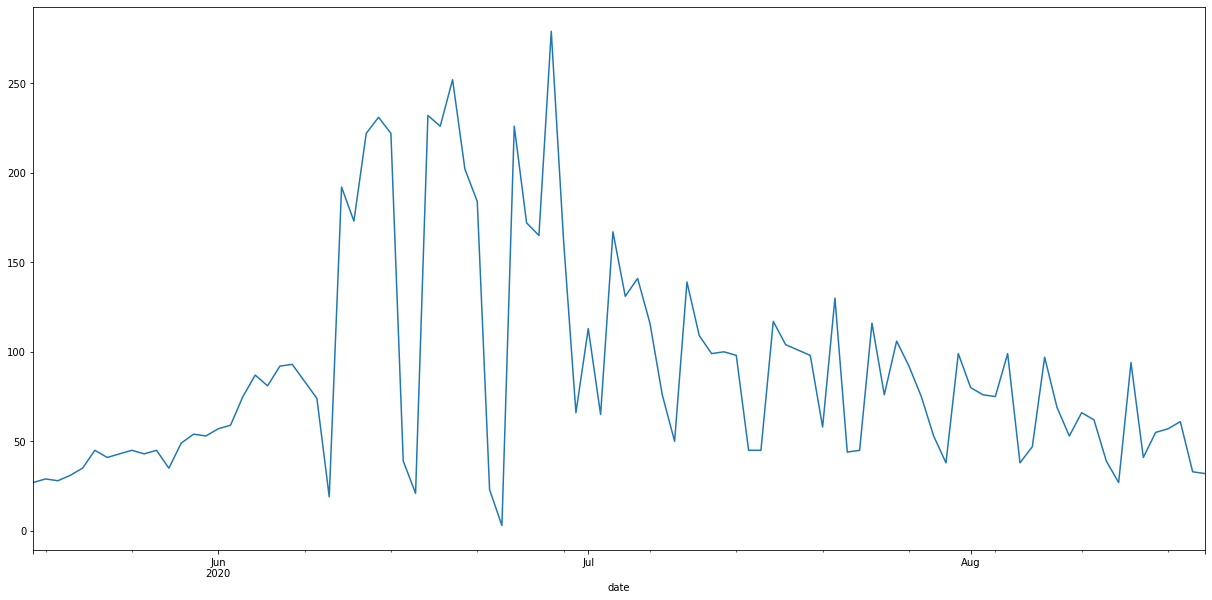

In [43]:
datos_chile_train['new_deaths'].plot(figsize=(21,10))

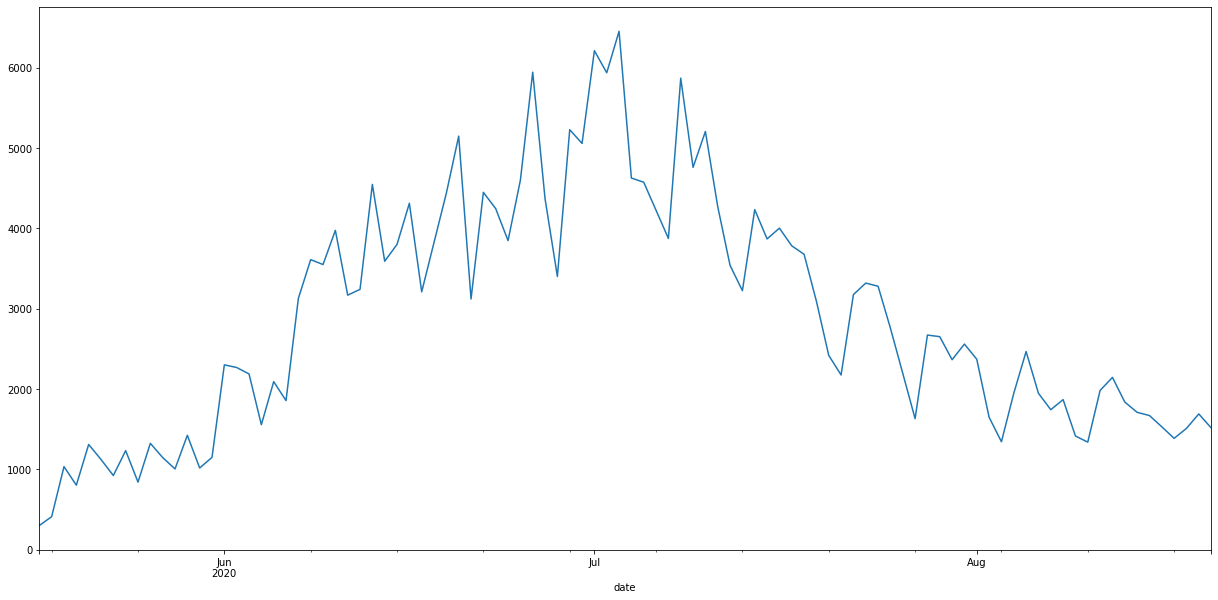

In [44]:
datos_chile_train['new_cases_sintomas'].plot(figsize=(21,10))

In [45]:
model_auto1 = auto_arima(datos_chile_train.new_deaths[1:],exogenous=datos_chile_train[['new_cases_sintomas']][1:], m = 5,
                       max_order = None, max_p = 7, max_q = 7, max_d = 2, max_P = 7, max_Q = 7, max_D = 2,
                       maxiter = 50, alpha = 0.05, n_jobs = -1, trend = 'ct', information_criterion = 'oob')

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/_validation.py:75: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)
/usr/local/lib/python3.6/dist-packages/pmdarima/arima/_validation.py:33: UserWarning: information_criterion cannot be 'oob' with out_of_sample_size = 0. Falling back to information criterion = aic.
  warnings.warn('information_criterion cannot be \'oob\' with '
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to con

In [46]:
model_auto1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   95
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 5)   Log Likelihood                -501.576
Date:                            Mon, 31 Aug 2020   AIC                           1015.152
Time:                                    03:27:04   BIC                           1030.475
Sample:                                05-18-2020   HQIC                          1021.344
                                     - 08-20-2020                                         
Covariance Type:                              opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept             40.1498     34.249      1.172      0.241     -26.977     107.277
drift                 -0.2395      0.458     -0.523      0.601      -1.137       0.658
new_cases_sintomas     0.0226      0.005      4.387      0.000       0.013       0.033
ma.L1                  0.4515      0.083      5.439      0.000       0.289       0.614
ar.S.L5               -0.1694      0.078     -2.165      0.030      -0.323      -0.016
sigma2              2226.8818    296.175      7.519      0.000    1646.389    2807.374
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                19.05
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                             0.85
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [48]:
model_sarima= SARIMAX(datos_chile_train['new_deaths'],exog=datos_chile_train[['new_cases_sintomas']], order=(0,0,1), seasonal_order=(0,0,1,5))
results_sarima=model_sarima.fit()
results_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        new_deaths   No. Observations:                   96
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 5)   Log Likelihood                -509.095
Date:                           Mon, 31 Aug 2020   AIC                           1026.191
Time:                                   03:27:04   BIC                           1036.448
Sample:                               05-17-2020   HQIC                          1030.337
                                    - 08-20-2020                                         
Covariance Type:                             opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
new_cases_sintomas     0.0292      0.002     16.003      0.000       0.026       0.033
ma.L1                  0.4523      0.081      5.597      0.000       0.294       0.611
ma.S.L5               -0.1805      0.088     -2.055      0.040      -0.353      -0.008
sigma2              2354.8747    281.465      8.367      0.000    1803.214    2906.535
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                10.11
Prob(Q):                              0.78   Prob(JB):                         0.01
Heteroskedasticity (H):               0.56   Skew:                             0.56
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
start=len(datos_chile_train)
end=len(datos_chile_train)+len(datos_chile_test)-1

In [50]:
predictions=results_sarima.predict(exog=datos_chile_test[['new_cases_sintomas']],start=start, end=end).rename('SARIMA')

In [51]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={datos_chile_test['new_deaths'][i]}")

predicted=36.09998276, expected=52.0
predicted=26.38011314, expected=69.0
predicted=37.44180479, expected=60.0
predicted=41.73770238, expected=64.0
predicted=47.70256464, expected=42.0
predicted=50.19582048, expected=32.0
predicted=41.76756327, expected=82.0
predicted=45.74542644, expected=60.0
predicted=33.66559196, expected=49.0
predicted=32.96361611, expected=49.0


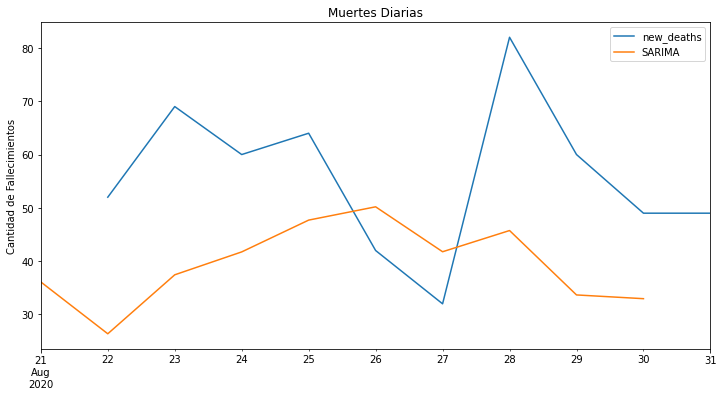

In [52]:
title ='Muertes Diarias'
ylabel='Cantidad de Fallecimientos'
xlabel=''

ax = datos_chile_test['new_deaths'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Reentrenando el modelo para predecir el futuro

In [57]:
model = SARIMAX(datos_chile_historicos['new_deaths'],exog=datos_chile_historicos['new_cases_sintomas'], order=(0,0,1),seasonal_order=(0,0,1,5))
results = model.fit()

In [70]:
datos_chile_historicos.tail()

,new_deaths,new_cases_sintomas
date,,
2020-08-27,32.0,1696.0
2020-08-28,82.0,1428.0
2020-08-29,60.0,1564.0
2020-08-30,49.0,1151.0
2020-08-31,49.0,1127.0


In [65]:
fcast = results.predict(len(datos_chile_forecast), exog=datos_chile_forecast['new_cases_sintomas']).rename('SARIMA(0,0,1)(0,0,1,5) Forecast')

In [71]:
fcast = results.predict(len(datos_chile_historicos), len(datos_chile_historicos) + 16, exog=datos_chile_forecast['new_cases_sintomas']).rename('SARIMA(0,0,1)(0,0,1,5) Forecast')

In [72]:
fcast

2020-09-01    42.631240
2020-09-02    37.072993
2020-09-03    31.233244
2020-09-04    42.951526
2020-09-05    30.013470
2020-09-06    30.012409
2020-09-07    21.470713
2020-09-08    38.759203
2020-09-09    38.877012
2020-09-10    40.791410
2020-09-11    40.555792
2020-09-12    42.116763
2020-09-13    32.426962
2020-09-14    27.390622
2020-09-15    35.166024
2020-09-16    36.079045
2020-09-17    41.851692
Freq: D, Name: SARIMA(0,0,1)(0,0,1,5) Forecast, dtype: float64

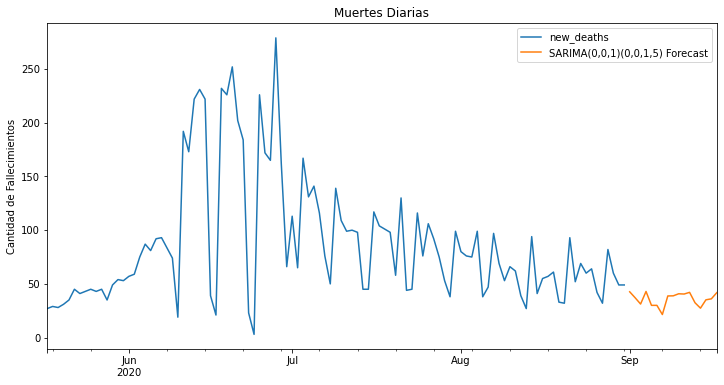

In [73]:
title ='Muertes Diarias'
ylabel='Cantidad de Fallecimientos'
xlabel=''

ax = datos_chile_historicos['new_deaths'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [ ]:
datos_chile_historicos['new_cases_sintomas'].plot(figsize=(12,20))

In [ ]:
model_auto_case= auto_arima(datos_chile_forecast.new_cases_sintomas[1:], m = 5,
                       max_order = None, max_p = 10, max_q = 10, max_d = 2, max_P = 10, max_Q = 10, max_D = 2,
                       maxiter = 50, alpha = 0.05, n_jobs = -1, trend = 'ct', information_criterion = 'oob')

In [ ]:
model_auto_case.summary()